In [1]:
import pandas as pd
from pandas_datareader import data
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf
from pytrends.request import TrendReq
import numpy as np
import newsapi
#from newsapi.articles import Articles
#from newsapi import NewsApiClient
import requests
from pytrends.request import TrendReq
import numpy as np
import statsmodels.api as sm
import collections
from itertools import count
from collections import OrderedDict
from scipy import stats
import seaborn as sns
from pandas.tools.plotting import table
#from sklearn.model_selection import cross_val_score
#import sklearn.metrics as skmetric


pd.options.mode.chained_assignment = None
import math



/Users/shaeferdrew/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Stock Data

In [2]:
stock = 'AMD'
start = '2015-10-08'
end = '2018-10-08'

In [3]:
amd = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 downloaded


In [4]:
amd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-10-08,1.87,1.95,1.85,1.93,1.93,9198700
2015-10-09,1.92,1.96,1.89,1.96,1.96,8629100
2015-10-12,1.96,1.96,1.85,1.87,1.87,7686600
2015-10-13,1.87,1.94,1.86,1.92,1.92,6698400
2015-10-14,1.92,1.96,1.92,1.95,1.95,10184300


In [5]:
len(amd)

756

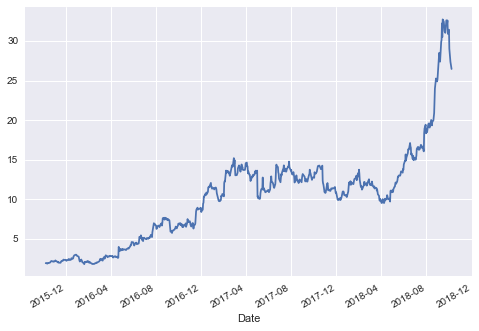

In [6]:
amd = amd.Close
amd.plot()

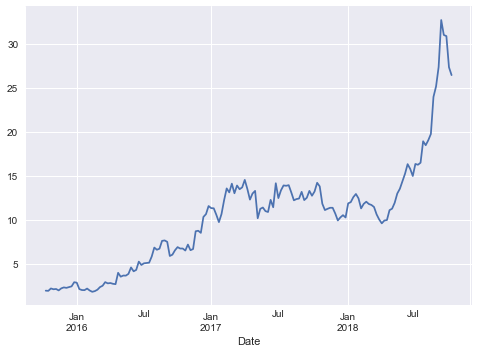

In [7]:
amd.resample('W').last().plot()

In [8]:
weekly_amd = pd.DataFrame(amd.resample('W').last())
weekly_amd.head()

,Close
Date,
2015-10-11,1.96
2015-10-18,1.94
2015-10-25,2.21
2015-11-01,2.12
2015-11-08,2.15


In [9]:
weekly_amd.tail()

,Close
Date,
2018-09-16,32.720001
2018-09-23,31.020000
2018-09-30,30.889999
2018-10-07,27.350000
2018-10-14,26.459999


## Google Trends Data

In [10]:
pytrends = TrendReq(hl='en-US', tz=360)

In [11]:
kw_list = [stock] #can try with neg and pos phrases like "buy amd", "sell amd"
pytrends.build_payload(kw_list, cat = 7, timeframe=start + ' ' + end)

In [12]:
amd_trend = pytrends.interest_over_time()
amd_trend = amd_trend[[stock]]
amd_trend.head()

,AMD
date,
2015-10-11,16
2015-10-18,15
2015-10-25,13
2015-11-01,15
2015-11-08,16


In [13]:
amd_trend.head()

,AMD
date,
2015-10-11,16
2015-10-18,15
2015-10-25,13
2015-11-01,15
2015-11-08,16


In [14]:
#amd_trend = amd_trend.shift(periods = 1, freq = 'W')

In [15]:
len(amd_trend)

157

In [16]:
combined = weekly_amd.merge(amd_trend, left_index = True, right_index = True, how = 'outer')
df_amd = combined.rename(columns = {'Close': 'price', stock: 'num_searches'})
df_amd = df_amd.dropna() #only drops first and last date which don't match up
df_amd.head()

,price,num_searches
2015-10-11,1.96,16.0
2015-10-18,1.94,15.0
2015-10-25,2.21,13.0
2015-11-01,2.12,15.0
2015-11-08,2.15,16.0


In [17]:
df_amd.tail()

,price,num_searches
2018-09-09,27.379999,100.0
2018-09-16,32.720001,72.0
2018-09-23,31.020000,63.0
2018-09-30,30.889999,66.0
2018-10-07,27.350000,58.0


In [18]:
#df_amd.to_csv('amd1215.csv')

In [19]:
#******reads from cache since api doesn't always respond***
# df_amd = pd.read_csv('amd.csv', index_col = 0)
# df_amd.head()

In [20]:
len(df_amd)

157

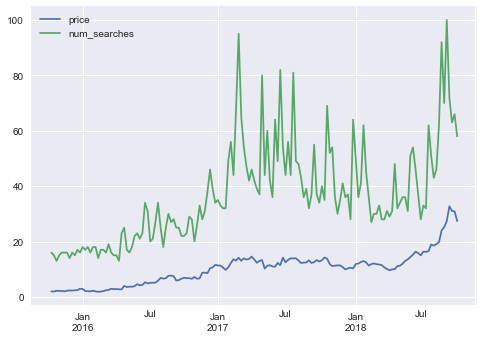

In [21]:
df_amd.plot()

In [22]:
rolling_price = df_amd['price'].rolling(window = 5, center = True, min_periods = 1)
rolling_trend = df_amd['num_searches'].rolling(window = 5, center = True, min_periods = 1)
df_amd['rolling_price'] = rolling_price.mean()
df_amd['rolling_trend'] = rolling_trend.mean()
df_amd.head()

,price,num_searches,rolling_price,rolling_trend
2015-10-11,1.96,16.0,2.036667,14.666667
2015-10-18,1.94,15.0,2.057500,14.750000
2015-10-25,2.21,13.0,2.076000,15.000000
2015-11-01,2.12,15.0,2.082000,15.000000
2015-11-08,2.15,16.0,2.138000,15.200000


In [23]:
df_amd.tail()

,price,num_searches,rolling_price,rolling_trend
2018-09-09,27.379999,100.0,28.054000,79.400000
2018-09-16,32.720001,72.0,29.436000,74.200000
2018-09-23,31.020000,63.0,29.872000,71.800000
2018-09-30,30.889999,66.0,30.495000,64.750000
2018-10-07,27.350000,58.0,29.753333,62.333333


## Cross correlation

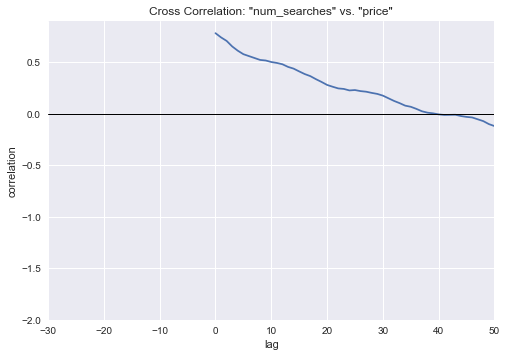

In [24]:
ccf = sm.tsa.stattools.ccf(df_amd['num_searches'], df_amd['price'] )

plt.plot(ccf)
plt.xlim(-30,50)
plt.ylim(-2, 0.9)
plt.axhline(0, color="black", linewidth=1)
plt.title('Cross Correlation: "num_searches" vs. "price"')
plt.xlabel('lag')
plt.ylabel('correlation')

In [25]:
ccf[0:40]

array([ 0.78018806,  0.73908627,  0.70509072,  0.6512855 ,  0.61009664,
        0.57640926,  0.55782948,  0.53986085,  0.52061891,  0.51523079,
        0.50056765,  0.49130613,  0.47869659,  0.45318713,  0.43633387,
        0.4093091 ,  0.38355293,  0.36353982,  0.33411463,  0.30736064,
        0.27824905,  0.26059567,  0.24439498,  0.23934033,  0.22488549,
        0.22848592,  0.21823747,  0.21249292,  0.20094487,  0.19108176,
        0.17432907,  0.14827035,  0.12303337,  0.1015289 ,  0.07719547,
        0.06624193,  0.0459466 ,  0.02269009,  0.00909967,  0.00258822])

### cross correlation confirms no lag

In [26]:
np.corrcoef(df_amd['num_searches'], df_amd['price'])

array([[ 1.        ,  0.78018806],
       [ 0.78018806,  1.        ]])

#### High correlation between number of searches and price for this time interval

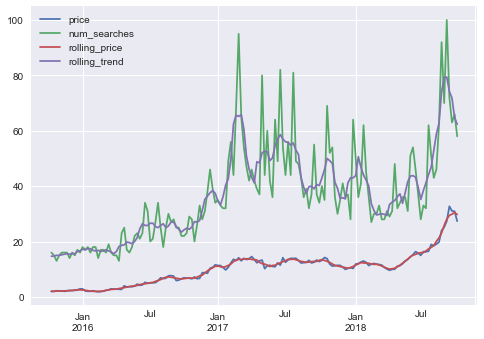

In [27]:
df_amd.plot()

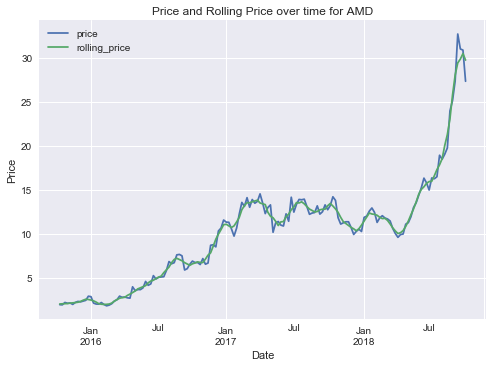

In [28]:
df_amd[['price', 'rolling_price']].plot()
plt.title('Price and Rolling Price over time for '+stock)
plt.xlabel('Date')
plt.ylabel('Price')

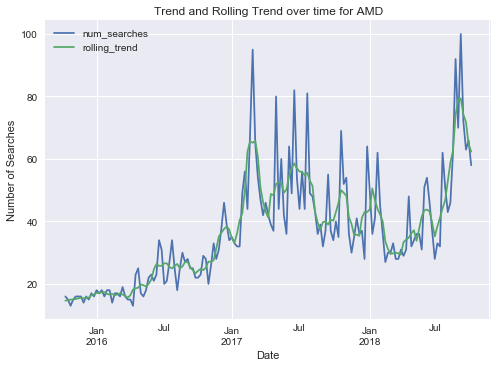

In [29]:
df_amd[['num_searches', 'rolling_trend']].plot()
plt.title('Trend and Rolling Trend over time for '+stock)
plt.xlabel('Date')
plt.ylabel('Number of Searches')

In [30]:
df_amd['trend_diff'] = df_amd['num_searches'] - df_amd['rolling_trend']
df_amd['price_diff'] = df_amd['price'] - df_amd['rolling_price']

In [31]:
#split into training and test data
threshold = int(.7 * len(df_amd))
df_train = df_amd[:threshold]
df_test = df_amd[threshold:]

In [32]:
# threshold = int(.8 * len(df_amd))
# df_train = df_amd[:threshold]
# df_test = df_amd[threshold:]

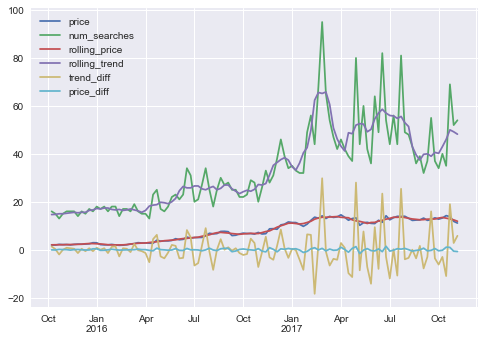

In [33]:
df_train.plot()

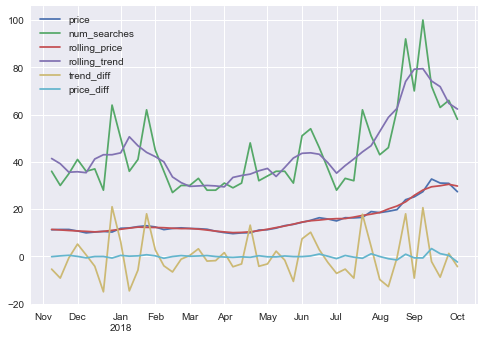

In [34]:
df_test.plot()

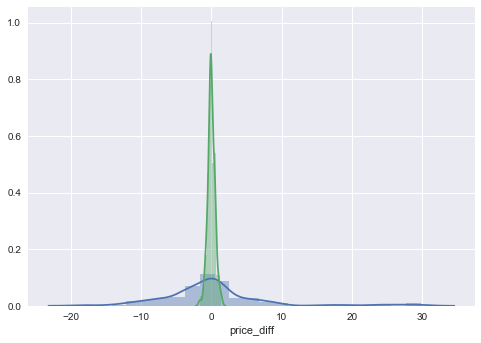

In [36]:
sns.distplot(df_train['trend_diff'])
sns.distplot(df_train['price_diff'])

### Normalize price and trend differences from moving averages

In [37]:
df_train_norm = df_train.copy()
#get z-score
df_train_norm.iloc[:,4:6] = df_train_norm.apply(lambda x: (x-np.mean(x))/np.std(x))
df_train_norm.tail()

,price,num_searches,rolling_price,rolling_trend,trend_diff,price_diff
2017-10-08,13.23,40.0,13.462,43.0,-0.412686,-0.461057
2017-10-15,14.22,35.0,13.170,46.0,-1.473651,2.088510
2017-10-22,13.81,69.0,12.844,50.0,2.504970,1.921456
2017-10-29,11.84,52.0,12.450,49.2,0.356514,-1.212801
2017-11-05,11.12,54.0,11.882,48.2,0.754377,-1.515090


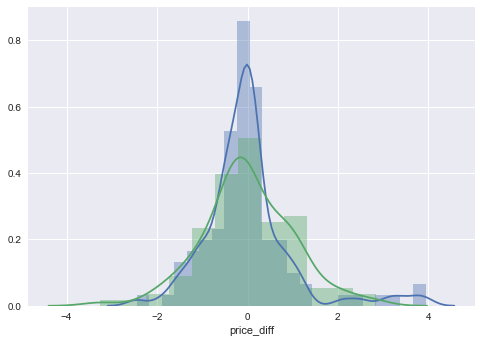

In [38]:
sns.distplot(df_train_norm['trend_diff'])
sns.distplot(df_train_norm['price_diff'])

In [39]:
df_train_norm.describe()

,price,num_searches,rolling_price,rolling_trend,trend_diff,price_diff
count,109.000000,109.000000,109.000000,109.000000,1.090000e+02,1.090000e+02
mean,7.904771,33.220183,7.904937,33.108410,-2.037106e-17,-4.074213e-18
std,4.458441,17.381002,4.411213,15.175313,1.004619e+00,1.004619e+00
min,1.830000,13.000000,1.988000,14.666667,-2.455045e+00,-3.265183e+00
25%,2.930000,18.000000,3.162000,18.600000,-4.922581e-01,-5.087865e-01
50%,7.200000,30.000000,7.098000,27.000000,-4.134765e-02,-9.512815e-02
75%,12.310000,43.000000,12.494000,46.200000,1.973696e-01,7.242335e-01
max,14.550000,95.000000,13.834000,65.800000,3.937274e+00,2.832300e+00


In [40]:
np.corrcoef(df_train_norm['rolling_trend'], df_train_norm['rolling_price'])

array([[ 1.        ,  0.93268552],
       [ 0.93268552,  1.        ]])

#### Very strong correlation for moving averages for this time interval

In [41]:
def crossed_line(df):
    cross_lst = [False]
    for i in range(len(df['price_diff']) - 1):
        if(((df['price_diff'][i] < 0) & (df['price_diff'][i+1] > 0)) |\
        ((df['price_diff'][i] > 0) & (df['price_diff'][i+1] < 0))):
            cross_lst.append(True)
        else:
            cross_lst.append(False)
    return cross_lst

In [101]:
#Extract interval ranges from training data
pd_q75, pd_q60, pd_q40, pd_q25 = np.percentile(df_train_norm['price_diff'], [75, 60, 40, 25])
td_q75, td_q60, td_q40, td_q25 = np.percentile(df_train_norm['trend_diff'], [75, 60, 40, 25])

In [43]:
MY_RISK = 10
BASE_RISK = 10
MY_PORTFOLIO = 1000


In [46]:
#if price diff is greater than 75% interval and trend diff is less than 60%, short.
#if price diff is less than 25% interval and trend diff greater than 40%, buy.
#if trend diff is greater than 75% interval and price diff is less than 60%, buy
#if trend diff is less than 25% interval and price diff is greater than 40%, short
#if we have positions and the price crosses the rolling price (goes from pos to neg or neg to pos price diff),
#close positions
#else: hold
num_positions = 0
num_short = 0
num_long = 0

def reco(df, risk = MY_RISK):
    global num_positions, num_short, num_long
    
    if((df['price_diff'] > pd_q75) & (df['trend_diff'] < td_q60)):
        num_positions += risk
        num_short += risk
        if(num_long > 0):
            num_positions = risk
            num_long = 0
            return 'sell and short'
        return 'short'
    elif((df['price_diff'] < pd_q25) & (df['trend_diff'] > td_q40)):
        num_positions += risk
        num_long += risk
        if(num_short > 0):
            num_positions = risk
            num_short = 0
            return 'cover and buy'
        return 'buy'
    elif((df['trend_diff'] > td_q75) & (df['price_diff'] < pd_q60)):
        num_positions += risk
        num_long += risk
        if(num_short > 0):
            num_positions = risk
            num_short = 0
            return 'cover and buy'
        return 'buy'
    elif((df['trend_diff'] < td_q25) & (df['price_diff'] > pd_q40)):
        num_positions += risk
        num_short += risk
        if(num_long > 0):
            num_positions = risk
            num_long = 0
            return 'sell and short'
        return 'short'

    elif((df['crossed'] == True) & (num_positions > 0)):
        num_positions = 0
        if(num_short > 0):
            num_short = 0
            return 'cover'
        if(num_long > 0):
            num_long = 0
            return 'sell'
    else:
        return 'hold'

In [47]:
base_positions = 0
base_short = 0
base_long = 0
def base_reco(df, risk = BASE_RISK):
    global base_positions, base_short, base_long
    if(df['trend_change'] > 0):
        base_positions += risk
        base_long += risk
        if(base_short > 0):
            base_positions = risk
            base_short = 0
            return 'cover and buy'
        return 'buy'
    elif(df['trend_change'] < 0):
        base_positions += risk
        base_short += risk
        if(base_long > 0):
            base_positions = risk
            base_long = 0
            return 'sell and short'
        return 'short'
    else:
        return 'hold'

In [48]:
num_positions = 0
def pos_count(df, risk = MY_RISK):
    global num_positions
    if((df['recommendation'] == 'sell') | (df['recommendation'] == 'cover')):
        num_positions = 0
    elif((df['recommendation'] == 'short') | (df['recommendation'] == 'buy')):
        num_positions += risk
    elif((df['recommendation'] == 'sell and short') | (df['recommendation'] == 'cover and buy')):
        num_positions = risk
    return num_positions

In [49]:
base_positions = 0
def base_pos_count(df, risk = BASE_RISK):
    global base_positions
    if((df['baseline_rec'] == 'sell') | (df['baseline_rec'] == 'cover')):
        base_positions = 0
    elif((df['baseline_rec'] == 'short') | (df['baseline_rec'] == 'buy')):
        base_positions += risk
    elif((df['baseline_rec'] == 'sell and short') | (df['baseline_rec'] == 'cover and buy')):
        base_positions = risk
    return base_positions

In [50]:
num_short = 0
def short_count(df, risk = MY_RISK):
    global num_short
    if(df['recommendation'] == 'short'):
        num_short += risk
        
    elif(df['recommendation'] == 'sell and short'):
        num_short += risk
    
    elif(df['recommendation'] == 'cover'):
        num_short = 0
        
    elif(df['recommendation'] == 'cover and buy'):
        num_short = 0
        
    return num_short

In [51]:
base_short = 0
def base_short_count(df, risk = BASE_RISK):
    global base_short
    #print(base_short)
    if(df['baseline_rec'] == 'short'):
        base_short += risk
        
    elif(df['baseline_rec'] == 'sell and short'):
        base_short += risk
    
    elif(df['baseline_rec'] == 'cover'):
        base_short = 0
        
    elif(df['baseline_rec'] == 'cover and buy'):
        base_short = 0
    return base_short

In [52]:
num_long = 0
def long_count(df, risk = MY_RISK):
    global num_long
    if(df['recommendation'] == 'buy'):
        num_long += risk
        
    elif(df['recommendation'] == 'cover and buy'):
        num_long += risk
    
    elif(df['recommendation'] == 'sell'):
        num_long = 0
        
    elif(df['recommendation'] == 'sell and short'):
        num_long = 0
        
    return num_long

In [53]:
base_long = 0
def base_long_count(df, risk = BASE_RISK):
    global base_long
    if(df['baseline_rec'] == 'buy'):
        base_long += risk
        
    elif(df['baseline_rec'] == 'cover and buy'):
        base_long += risk
    
    elif(df['baseline_rec'] == 'sell'):
        base_long = 0
        
    elif(df['baseline_rec'] == 'sell and short'):
        base_long = 0
        
    return base_long

### Normalize price and trend differences in test data

In [54]:
#get z-score
df_test_norm = df_test.copy()
df_test_norm.iloc[:,4:6] = df_test_norm.apply(lambda x: (x-np.mean(x))/np.std(x))
df_test_norm.tail()

,price,num_searches,rolling_price,rolling_trend,trend_diff,price_diff
2018-09-09,27.379999,100.0,28.054000,79.400000,2.364372,-0.820863
2018-09-16,32.720001,72.0,29.436000,74.200000,-0.218333,4.140400
2018-09-23,31.020000,63.0,29.872000,71.800000,-0.965958,1.462973
2018-09-30,30.889999,66.0,30.495000,64.750000,0.172471,0.519103
2018-10-07,27.350000,58.0,29.753333,62.333333,-0.459989,-2.988540


In [55]:
df_test_norm['crossed'] = crossed_line(df_test_norm)
df_test_norm.head()

,price,num_searches,rolling_price,rolling_trend,trend_diff,price_diff,crossed
2017-11-12,11.26,36.0,11.396,41.4,-0.580817,-0.146491,False
2017-11-19,11.38,30.0,11.174,39.2,-1.011268,0.282198,True
2017-11-26,11.38,35.0,10.938,35.6,-0.037090,0.578018,False
2017-12-03,10.73,41.0,10.744,35.8,0.619914,0.006433,False
2017-12-10,9.94,36.0,10.576,35.4,0.098842,-0.773230,True


In [56]:
base_test_norm = df_test_norm.copy()

In [57]:
def trend_change(df):
    trend_diff = [0]
    for i in range(len(df_test_norm)-1):
        trend_diff.append(df.num_searches.iloc[i+1] - df.num_searches.iloc[i])
    df['trend_change'] = trend_diff

In [58]:
trend_change(base_test_norm)
base_test_norm.head()

,price,num_searches,rolling_price,rolling_trend,trend_diff,price_diff,crossed,trend_change
2017-11-12,11.26,36.0,11.396,41.4,-0.580817,-0.146491,False,0.0
2017-11-19,11.38,30.0,11.174,39.2,-1.011268,0.282198,True,-6.0
2017-11-26,11.38,35.0,10.938,35.6,-0.037090,0.578018,False,5.0
2017-12-03,10.73,41.0,10.744,35.8,0.619914,0.006433,False,6.0
2017-12-10,9.94,36.0,10.576,35.4,0.098842,-0.773230,True,-5.0


In [59]:
portfolio_value = MY_PORTFOLIO
def invest(df, risk = MY_RISK):
    global portfolio_value
    if(df['recommendation'] == 'buy'):
        portfolio_value -= (df['price'] * risk)
    #if(df['recommendation'] == 'hold'):

    if(df['recommendation'] == 'short'):
        portfolio_value += (df['price'] * risk)
        
    if(df['recommendation'] == 'sell'):
        portfolio_value += (df['price'] * df['long_change'])
        
    if(df['recommendation'] == 'sell and short'):
        portfolio_value += (df['price'] * df['long_change']) + (df['price'] * risk)
    
    if(df['recommendation'] == 'cover'):
        portfolio_value -= (df['price'] * df['short_change'])
        
    if(df['recommendation'] == 'cover and buy'):
        portfolio_value -= (df['price'] * df['short_change']) + (df['price'] * risk)
    return portfolio_value

In [60]:
base_portfolio_value = MY_PORTFOLIO
def base_invest(df, risk = BASE_RISK):
    global base_portfolio_value
    if(df['baseline_rec'] == 'buy'):
        base_portfolio_value -= (df['price'] * risk)

    if(df['baseline_rec'] == 'short'):
        base_portfolio_value += (df['price'] * risk)
        
    if(df['baseline_rec'] == 'sell'):
        base_portfolio_value += (df['price'] * df['long_change'])
        
    if(df['baseline_rec'] == 'sell and short'):
        base_portfolio_value += (df['price'] * df['long_change']) + (df['price'] * risk)
    
    if(df['baseline_rec'] == 'cover'):
        base_portfolio_value -= (df['price'] * df['short_change'])
        
    if(df['baseline_rec'] == 'cover and buy'):
        base_portfolio_value -= (df['price'] * df['short_change']) + (df['price'] * risk)
    return base_portfolio_value

In [61]:
def base_leverage_used(df):
    if ((df['portfolio_value'] > (MY_PORTFOLIO + df['revenue'])) | (df['portfolio_value'] < (MY_PORTFOLIO - df['revenue']))) & (df['baseline_rec'] != 'hold'):
        return True
    else:
        return False

In [62]:
def leverage_used(df):
    if ((df['portfolio_value'] > (MY_PORTFOLIO + df['revenue'])) | (df['portfolio_value'] < (MY_PORTFOLIO - df['revenue']))) & (df['recommendation'] != 'hold'):
        return True
    else:
        return False

In [63]:
base_test_norm['baseline_rec'] = base_test_norm.apply(base_reco, axis = 1)

In [64]:
def base_backtest():
    global base_positions, base_short, base_long, base_portfolio_value
    base_positions = 0
    base_short = 0
    base_long = 0
    base_portfolio_value = MY_PORTFOLIO
    base_test_norm['num_positions'] = base_test_norm.apply(base_pos_count, risk = BASE_RISK, axis = 1)
    base_test_norm['num_long'] = base_test_norm.apply(base_long_count, risk = BASE_RISK, axis = 1)
    base_test_norm['num_short'] = base_test_norm.apply(base_short_count, risk = BASE_RISK, axis = 1)
    short_change_lst = [0]
    long_change_lst = [0]
    for i in range(len(base_test_norm)-1):
        short_change_lst.append(abs(base_test_norm.num_short.iloc[i+1] - base_test_norm.num_short.iloc[i]))
        long_change_lst.append(abs(base_test_norm.num_long.iloc[i+1] - base_test_norm.num_long.iloc[i]))
    base_test_norm['short_change'] = short_change_lst
    base_test_norm['long_change'] = long_change_lst
    base_test_norm['portfolio_value'] = base_test_norm.apply(base_invest, risk = BASE_RISK, axis = 1)
    base_test_norm['profit'] = (base_test_norm['portfolio_value'] - (base_test_norm['num_short'] * base_test_norm['price']) + (base_test_norm['num_long'] * base_test_norm['price'])) -\
    MY_PORTFOLIO
    base_test_norm['revenue'] = (base_test_norm['portfolio_value'] - (base_test_norm['num_short'] * base_test_norm['price']) + (base_test_norm['num_long'] * base_test_norm['price']))
    #base_test_norm['baseline_rec'] = base_test_norm.apply(base_reco, axis = 1)
    base_test_norm['leverage_used'] = base_test_norm.apply(base_leverage_used, axis = 1)

In [65]:
def my_backtest():
    global num_positions, num_short, num_long, portfolio_value
    num_positions = 0
    num_short = 0
    num_long = 0
    portfolio_value = MY_PORTFOLIO
    df_test_norm['num_positions'] = df_test_norm.apply(pos_count, risk = MY_RISK, axis = 1)
    df_test_norm['num_long'] = df_test_norm.apply(long_count, risk = MY_RISK, axis = 1)
    df_test_norm['num_short'] = df_test_norm.apply(short_count, risk = MY_RISK, axis = 1)
    short_change_lst = [0]
    long_change_lst = [0]
    for i in range(len(df_test_norm)-1):
        short_change_lst.append(abs(df_test_norm.num_short.iloc[i+1] - df_test_norm.num_short.iloc[i]))
        long_change_lst.append(abs(df_test_norm.num_long.iloc[i+1] - df_test_norm.num_long.iloc[i]))
    df_test_norm['short_change'] = short_change_lst
    df_test_norm['long_change'] = long_change_lst
    df_test_norm['portfolio_value'] = df_test_norm.apply(invest, risk = MY_RISK, axis = 1)
    df_test_norm['profit'] = (df_test_norm['portfolio_value'] - (df_test_norm['num_short'] * df_test_norm['price']) + (df_test_norm['num_long'] * df_test_norm['price'])) - \
    MY_PORTFOLIO
    df_test_norm['revenue'] = (df_test_norm['portfolio_value'] - (df_test_norm['num_short'] * df_test_norm['price']) + (df_test_norm['num_long'] * df_test_norm['price']))
    #base_test_norm['baseline_rec'] = base_test_norm.apply(base_reco, axis = 1)
    df_test_norm['leverage_used'] = df_test_norm.apply(leverage_used, axis = 1)

In [66]:
def profit_change(df):
    profit_diff = [0]
    for i in range(len(df)-1):
        profit_diff.append(df.profit.iloc[i+1] - df.profit.iloc[i])
    df['profit_change'] = profit_diff

In [67]:
def buy_n_hold_p_change(df):
    profit_diff = [0]
    for i in range(len(df)-1):
        profit_diff.append(df.buy_n_hold_prof.iloc[i+1] - df.buy_n_hold_prof.iloc[i])
    df['buy_n_hold_p_change'] = profit_diff

In [68]:
def price_change(df):
    price_change = []
    for i in range(len(df)-1):
        price_change.append(df.price.iloc[i+1] - df.price.iloc[i])
    price_change.append(0.0)
    df['price_change'] = price_change

In [69]:
def precision(df):
    if ((df['price_change'] > 0) & ((df['recommendation'] == 'buy') | (df['recommendation'] == 'cover and buy')\
                                    | (df['recommendation'] == 'cover')))\
    | ((df['price_change'] < 0) & ((df['recommendation'] == 'short') | (df['recommendation'] == 'sell and short')\
                                  | (df['recommendation'] == 'sell'))):
        return 1
    elif (df['recommendation'] == 'hold'):
        return 2
    else:
        return 0

In [70]:
def base_precision(df):
    if ((df['price_change'] > 0) & ((df['baseline_rec'] == 'buy') | (df['baseline_rec'] == 'cover and buy')\
                                    | (df['baseline_rec'] == 'cover')))\
    | ((df['price_change'] < 0) & ((df['baseline_rec'] == 'short') | (df['baseline_rec'] == 'sell and short')\
                                  | (df['baseline_rec'] == 'sell'))):
        return 1
    elif (df['baseline_rec'] == 'hold'):
        return 2
    else:
        return 0

In [72]:
#list of risk levels to test
my_risks = list(np.arange(1,200, 1))
base_risks = list(np.arange(1,200, 1))

In [73]:
MY_PORTFOLIO = 1000
precisions = []
profits = []
posn_profit_changes = []
count = 0
for risk in base_risks:
    BASE_RISK = risk
    base_test_norm['baseline_rec'] = base_test_norm.apply(base_reco,risk = risk, axis = 1)
    base_backtest()
    
    base_test_norm['leverage_used'] = base_test_norm.apply(base_leverage_used, axis = 1)
    #count = 0
    #print(risk)
    
    while(base_test_norm['leverage_used'].any()):
        if(count == 0):
            no_l_brisk = risk - 1 #minimum risk for no leverage
            print(no_l_brisk)
        count += 1
        if (base_test_norm.loc[base_test_norm[base_test_norm['leverage_used'] == True].index[0],'baseline_rec'] == 'sell and short'):
            base_test_norm.loc[base_test_norm[base_test_norm['leverage_used'] == True].index[0],'baseline_rec'] = 'sell'
        elif (base_test_norm.loc[base_test_norm[base_test_norm['leverage_used'] == True].index[0],'baseline_rec'] == 'cover and buy'):
            base_test_norm.loc[base_test_norm[base_test_norm['leverage_used'] == True].index[0],'baseline_rec'] = 'cover'
        else:
            base_test_norm.loc[base_test_norm[base_test_norm['leverage_used'] == True].index[0],'baseline_rec'] = 'hold'
        base_positions = 0
        base_short = 0
        base_long = 0
        base_portfolio_value = MY_PORTFOLIO
        base_backtest()

    price_change(base_test_norm)

    profit_change(base_test_norm)
    base_test_norm['precision'] = base_test_norm.apply(base_precision, axis = 1)
    precision = len(base_test_norm[base_test_norm['precision'] == 1])\
    / (len(base_test_norm[base_test_norm['precision'] == 0]) + len(base_test_norm[base_test_norm['precision'] == 1]))
    profit = base_test_norm[-1:]['profit'].values[0]
    posn_profit_change = len(base_test_norm[base_test_norm['profit_change'] >= 0]) / len(base_test_norm)
    
    
    
    precisions.append(precision)
    profits.append(profit)
    posn_profit_changes.append(posn_profit_change)
df_base_gs = pd.DataFrame(index = base_risks, data = \
                  {'precision': precisions, 'profit': profits, 'posn_profit_change':posn_profit_changes})
df_base_gs = df_base_gs.sort_values(by = 'profit', ascending = False)
df_base_gs.head()

16


,posn_profit_change,precision,profit
94,0.812500,0.535714,1471.100376
49,0.562500,0.575758,1144.150245
80,0.750000,0.517241,1141.600320
74,0.666667,0.517241,1129.980296
79,0.687500,0.517241,1127.330316


In [74]:
MY_PORTFOLIO = 1000
precisions = []
profits = []
posn_profit_changes = []
count = 0
for risk in my_risks:
    MY_RISK = risk
    def precision(df):
        if ((df['price_change'] > 0) & ((df['recommendation'] == 'buy') | (df['recommendation'] == 'cover and buy')\
                                        | (df['recommendation'] == 'cover')))\
        | ((df['price_change'] < 0) & ((df['recommendation'] == 'short') | (df['recommendation'] == 'sell and short')\
                                      | (df['recommendation'] == 'sell'))):
            return 1
        elif (df['recommendation'] == 'hold'):
            return 2
        else:
            return 0
    
    df_test_norm['recommendation'] = df_test_norm.apply(reco,risk = MY_RISK, axis = 1)
    my_backtest()
    
    df_test_norm['leverage_used'] = df_test_norm.apply(leverage_used, axis = 1)
    while(df_test_norm['leverage_used'].any()):
        if(count == 0):
            no_l_risk = risk - 1 #minimum risk for no leverage
            print(risk - 1)
        count += 1
        if (df_test_norm.loc[df_test_norm[df_test_norm['leverage_used'] == True].index[0],'recommendation'] == 'sell and short'):
            df_test_norm.loc[df_test_norm[df_test_norm['leverage_used'] == True].index[0],'recommendation'] = 'sell'
        elif (df_test_norm.loc[df_test_norm[df_test_norm['leverage_used'] == True].index[0],'recommendation'] == 'cover and buy'):
            df_test_norm.loc[df_test_norm[df_test_norm['leverage_used'] == True].index[0],'recommendation'] = 'cover'
        else:
            df_test_norm.loc[df_test_norm[df_test_norm['leverage_used'] == True].index[0],'recommendation'] = 'hold'
        num_positions = 0
        num_short = 0
        num_long = 0
        portfolio_value = MY_PORTFOLIO
        my_backtest()


    price_change(df_test_norm)
    df_test_norm['precision'] = df_test_norm.apply(precision, axis = 1)
    profit_change(df_test_norm)
    
    
    
    precision = len(df_test_norm[df_test_norm['precision'] == 1])\
    / (len(df_test_norm[df_test_norm['precision'] == 0]) + len(df_test_norm[df_test_norm['precision'] == 1]))
    profit = df_test_norm.iloc[-1:]['profit'].values[0]
    posn_profit_change = len(df_test_norm[df_test_norm['profit_change'] >= 0]) / len(df_test_norm)
    
    
    precisions.append(precision)
    profits.append(profit)
    posn_profit_changes.append(posn_profit_change)
    #df_test_norm = df_test_norm.drop(columns = 'precision')
df_my_gs = pd.DataFrame(index = my_risks, data = \
                  {'precision': precisions, 'profit': profits, 'posn_profit_change':posn_profit_changes})
df_my_gs = df_my_gs.sort_values(by = 'profit', ascending = False)
df_my_gs.head()

16


,posn_profit_change,precision,profit
100,0.979167,0.571429,1715.000300
99,0.979167,0.571429,1697.850297
98,0.979167,0.571429,1680.700294
97,0.979167,0.571429,1663.550291
96,0.979167,0.571429,1646.400288


#### This analysis uses a function to account for leverage, which reduces the amount of transactions made at once in cases where leverage would be used otherwise. The result is the risk value that returns the highest profit. 

#### At first I used this method to measure success, and it was successful in all 4 time intervals for AMD against its benchmarks. The problem is this method will often not adhere to the signal at all if its risk number is too large to use without leverage. Since it isn't considering all of the recommendations and since we don't know the optimal risk until after the test data is revealed, I instead used a method where I found the MAXIMUM RISK THAT ALLOWS FOR ALL RECOMMENDATIONS/SIGNALS WITHOUT USING LEVERAGE for both the baseline and my algorithm. These risks are represented by no_l_risk and no_l_brisk

In [77]:
BASE_RISK = no_l_brisk#df_base_gs.iloc[0].name
base_test_norm['baseline_rec'] = base_test_norm.apply(base_reco,risk = BASE_RISK, axis = 1)
base_backtest()

base_test_norm['leverage_used'] = base_test_norm.apply(base_leverage_used, axis = 1)

init_invest = base_test_norm['price'].iloc[0] * BASE_RISK
base_test_norm['buy_n_hold_rev'] = base_test_norm['price'] * BASE_RISK + (MY_PORTFOLIO - init_invest)#math.floor(MY_PORTFOLIO / base_test_norm['price'].iloc[0])
base_test_norm['buy_n_hold_prof'] = base_test_norm['buy_n_hold_rev'] - MY_PORTFOLIO
buy_n_hold_p_change(base_test_norm)

#uncomment to use a higher risk with the leverage accountability function
#count = 0
# while(base_test_norm['leverage_used'].any()):
#     if (base_test_norm.loc[base_test_norm[base_test_norm['leverage_used'] == True].index[0],'baseline_rec'] == 'sell and short'):
#         base_test_norm.loc[base_test_norm[base_test_norm['leverage_used'] == True].index[0],'baseline_rec'] = 'sell'
#     elif (base_test_norm.loc[base_test_norm[base_test_norm['leverage_used'] == True].index[0],'baseline_rec'] == 'cover and buy'):
#         base_test_norm.loc[base_test_norm[base_test_norm['leverage_used'] == True].index[0],'baseline_rec'] = 'cover'
#     else:
#         base_test_norm.loc[base_test_norm[base_test_norm['leverage_used'] == True].index[0],'baseline_rec'] = 'hold'
#     base_positions = 0
#     base_short = 0
#     base_long = 0
#     base_portfolio_value = MY_PORTFOLIO
#     base_backtest()

price_change(base_test_norm)
#print(base_test_norm)
profit_change(base_test_norm)
base_test_norm['precision'] = base_test_norm.apply(base_precision, axis = 1)
precision = len(base_test_norm[base_test_norm['precision'] == 1])\
/ (len(base_test_norm[base_test_norm['precision'] == 0]) + len(base_test_norm[base_test_norm['precision'] == 1]))
profit = base_test_norm[-1:]['profit'].values[0]
posn_profit_change = len(base_test_norm[base_test_norm['profit_change'] >= 0]) / len(base_test_norm)
buy_n_hold_posn_prof_change = len(base_test_norm[base_test_norm['buy_n_hold_p_change'] >= 0]) / len(base_test_norm)
df_base_results = pd.DataFrame(index = [BASE_RISK], data = \
                  {'precision': precision, 'profit': profit, 'posn_profit_change':posn_profit_change})
#df_my_gs = df_my_gs.sort_values(by = 'profit', ascending = False)
df_base_results.head()

,posn_profit_change,precision,profit
16,0.541667,0.5,299.040128


In [78]:
MY_RISK = no_l_risk#df_my_gs.iloc[0].name
def precision(df):
    #prec_score = 
    if ((df['price_change'] > 0) & ((df['recommendation'] == 'buy') | (df['recommendation'] == 'cover and buy')\
                                    | (df['recommendation'] == 'cover')))\
    | ((df['price_change'] < 0) & ((df['recommendation'] == 'short') | (df['recommendation'] == 'sell and short')\
                                  | (df['recommendation'] == 'sell'))):
        return 1
    elif (df['recommendation'] == 'hold'):
        return 2
    else:
        return 0

df_test_norm['recommendation'] = df_test_norm.apply(reco,risk = MY_RISK, axis = 1)
my_backtest()
#price_change(df_test_norm)

df_test_norm['leverage_used'] = df_test_norm.apply(leverage_used, axis = 1)
init_invest = df_test_norm['price'].iloc[0] * MY_RISK
df_test_norm['buy_n_hold_rev'] = df_test_norm['price'] * MY_RISK + (MY_PORTFOLIO - init_invest)#math.floor(MY_PORTFOLIO / base_test_norm['price'].iloc[0])
df_test_norm['buy_n_hold_prof'] = df_test_norm['buy_n_hold_rev'] - MY_PORTFOLIO

#uncomment to use a higher risk with the leverage accountability function
#while(df_test_norm['leverage_used'].any()):
#     if (df_test_norm.loc[df_test_norm[df_test_norm['leverage_used'] == True].index[0],'recommendation'] == 'sell and short'):
#         df_test_norm.loc[df_test_norm[df_test_norm['leverage_used'] == True].index[0],'recommendation'] = 'sell'
#     elif (df_test_norm.loc[df_test_norm[df_test_norm['leverage_used'] == True].index[0],'recommendation'] == 'cover and buy'):
#         df_test_norm.loc[df_test_norm[df_test_norm['leverage_used'] == True].index[0],'recommendation'] = 'cover'
#     else:
#         df_test_norm.loc[df_test_norm[df_test_norm['leverage_used'] == True].index[0],'recommendation'] = 'hold'
#     MY_RISK -= 1
#     num_positions = 0
#     num_short = 0
#     num_long = 0
#     portfolio_value = MY_PORTFOLIO
#     my_backtest()
    
    
#print(base_test_norm['baseline_rec'])
#     while(df_test_norm['leverage_used'].any()):
#         df_test_norm.loc[df_test_norm[df_test_norm['leverage_used'] == True].index[0],'recommendation'] = 'hold'
#         num_positions = 0
#         num_short = 0
#         num_long = 0
#         portfolio_value = MY_PORTFOLIO
#         my_backtest()

#print(risk)
price_change(df_test_norm)
df_test_norm['precision'] = df_test_norm.apply(precision, axis = 1)
profit_change(df_test_norm)


precision = len(df_test_norm[df_test_norm['precision'] == 1])\
/ (len(df_test_norm[df_test_norm['precision'] == 0]) + len(df_test_norm[df_test_norm['precision'] == 1]))
profit = df_test_norm.iloc[-1:]['profit'].values[0]
posn_profit_change = len(df_test_norm[df_test_norm['profit_change'] >= 0]) / len(df_test_norm)
df_my_results = pd.DataFrame(index = [MY_RISK], data = \
                  {'precision': precision, 'profit': profit, 'posn_profit_change':posn_profit_change})
#df_my_gs = df_my_gs.sort_values(by = 'profit', ascending = False)
df_my_results.head()

,posn_profit_change,precision,profit
16,0.8125,0.483871,452.00008


In [79]:
base_test_norm

,price,num_searches,rolling_price,rolling_trend,trend_diff,price_diff,crossed,trend_change,baseline_rec,num_positions,...,portfolio_value,profit,revenue,leverage_used,price_change,profit_change,precision,buy_n_hold_rev,buy_n_hold_prof,buy_n_hold_p_change
2017-11-12,11.260000,36.0,11.396000,41.400000,-0.580817,-0.146491,False,0.0,hold,0,...,1000.000000,0.000000e+00,1000.000000,False,0.120000,0.000000e+00,2,1000.000000,0.000000,0.000000
2017-11-19,11.380000,30.0,11.174000,39.200000,-1.011268,0.282198,True,-6.0,short,16,...,1182.080000,-1.136868e-13,1000.000000,False,0.000000,-1.136868e-13,0,1001.920000,1.920000,1.920000
2017-11-26,11.380000,35.0,10.938000,35.600000,-0.037090,0.578018,False,5.0,cover and buy,16,...,817.920000,-1.136868e-13,1000.000000,False,-0.650000,0.000000e+00,0,1001.920000,1.920000,0.000000
2017-12-03,10.730000,41.0,10.744000,35.800000,0.619914,0.006433,False,6.0,buy,32,...,646.240000,-1.040000e+01,989.600000,False,-0.790000,-1.040000e+01,0,991.520000,-8.480000,-10.400000
2017-12-10,9.940000,36.0,10.576000,35.400000,0.098842,-0.773230,True,-5.0,sell and short,16,...,1123.360000,-3.568000e+01,964.320000,False,0.350000,-2.528000e+01,0,978.880000,-21.120000,-12.640000
2017-12-17,10.290000,37.0,10.356000,41.200000,-0.444886,-0.058748,False,1.0,cover and buy,16,...,794.080000,-4.128000e+01,958.720000,False,0.250000,-5.600000e+00,1,984.480000,-15.520000,5.600000
2017-12-24,10.540000,28.0,10.586000,43.000000,-1.668272,-0.033678,False,-9.0,sell and short,16,...,1131.360000,-3.728000e+01,962.720000,False,-0.260000,4.000000e+00,1,988.480000,-11.520000,4.000000
2017-12-31,10.280000,64.0,11.002000,43.000000,2.409683,-0.881029,False,36.0,cover and buy,16,...,802.400000,-3.312000e+01,966.880000,False,1.600000,4.160000e+00,1,984.320000,-15.680000,-4.160000
2018-01-07,11.880000,50.0,11.462000,43.800000,0.733190,0.547935,True,-14.0,sell and short,16,...,1182.560000,-7.520000e+00,992.480000,False,0.140000,2.560000e+01,0,1009.920000,9.920000,25.600000
2018-01-14,12.020000,36.0,11.944000,50.600000,-1.622961,0.119246,False,-14.0,short,32,...,1374.880000,-9.760000e+00,990.240000,False,0.570000,-2.240000e+00,0,1012.160000,12.160000,2.240000


In [80]:
df_test_norm

,price,num_searches,rolling_price,rolling_trend,trend_diff,price_diff,crossed,recommendation,num_positions,num_long,...,long_change,portfolio_value,profit,revenue,leverage_used,price_change,precision,profit_change,buy_n_hold_rev,buy_n_hold_prof
2017-11-12,11.260000,36.0,11.396000,41.400000,-0.580817,-0.146491,False,short,16,0,...,0,1180.160000,1.136868e-13,1000.000000,False,0.120000,0,0.000000e+00,1000.000000,0.000000
2017-11-19,11.380000,30.0,11.174000,39.200000,-1.011268,0.282198,True,short,32,0,...,0,1362.240000,-1.920000e+00,998.080000,False,0.000000,0,-1.920000e+00,1001.920000,1.920000
2017-11-26,11.380000,35.0,10.938000,35.600000,-0.037090,0.578018,False,hold,32,0,...,0,1362.240000,-1.920000e+00,998.080000,False,-0.650000,2,0.000000e+00,1001.920000,1.920000
2017-12-03,10.730000,41.0,10.744000,35.800000,0.619914,0.006433,False,cover and buy,16,16,...,16,847.200000,1.888000e+01,1018.880000,False,-0.790000,0,2.080000e+01,991.520000,-8.480000
2017-12-10,9.940000,36.0,10.576000,35.400000,0.098842,-0.773230,True,buy,32,32,...,16,688.160000,6.240000e+00,1006.240000,False,0.350000,1,-1.264000e+01,978.880000,-21.120000
2017-12-17,10.290000,37.0,10.356000,41.200000,-0.444886,-0.058748,False,hold,32,32,...,0,688.160000,1.744000e+01,1017.440000,False,0.250000,2,1.120000e+01,984.480000,-15.520000
2017-12-24,10.540000,28.0,10.586000,43.000000,-1.668272,-0.033678,False,sell and short,16,0,...,32,1194.080000,2.544000e+01,1025.440000,False,-0.260000,1,8.000000e+00,988.480000,-11.520000
2017-12-31,10.280000,64.0,11.002000,43.000000,2.409683,-0.881029,False,cover and buy,16,16,...,16,865.120000,2.960000e+01,1029.600000,False,1.600000,1,4.160000e+00,984.320000,-15.680000
2018-01-07,11.880000,50.0,11.462000,43.800000,0.733190,0.547935,True,sell,0,0,...,16,1055.200000,5.520000e+01,1055.200000,False,0.140000,0,2.560000e+01,1009.920000,9.920000
2018-01-14,12.020000,36.0,11.944000,50.600000,-1.622961,0.119246,False,short,16,0,...,0,1247.520000,5.520000e+01,1055.200000,False,0.570000,0,0.000000e+00,1012.160000,12.160000


In [81]:
timeframe = str(df_amd.iloc[0].name).split('-')[0] + '-'+str(df_amd.iloc[-1].name).split('-')[0]

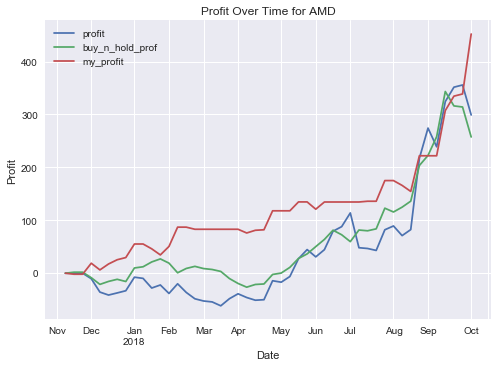

In [82]:
base_ax = base_test_norm[['profit', 'buy_n_hold_prof']].plot()
ax = df_test_norm['profit'].plot(label = 'my_profit')
ax.legend()
plt.title('Profit Over Time for '+stock)
plt.xlabel('Date')
plt.ylabel('Profit')
#plt.savefig(stock+'profchart'+timeframe+'.png')


In [83]:
df_base_gs['risk'] = df_base_gs.index.values
df_base_gs['timeframe'] = str(df_amd.iloc[0].name).split('-')[0] + '-'+str(df_amd.iloc[-1].name).split('-')[0]
df_base_gs = df_base_gs.reset_index(drop = True)

df_my_gs['risk'] = df_my_gs.index
df_my_gs['timeframe'] = str(df_amd.iloc[0].name).split('-')[0] + '-'+str(df_amd.iloc[-1].name).split('-')[0]
df_my_gs = df_my_gs.reset_index(drop = True)

In [87]:
#buy and hold strategy using base risk as the number of shares bought
buyholdprof = (base_test_norm['price'].iloc[-1] * BASE_RISK) - (base_test_norm['price'].iloc[0] * BASE_RISK)#base_test_norm[-1:]['buy_n_hold_prof'].values[0]

In [88]:
my_data = {'timeframe' :str(df_amd.iloc[0].name).split('-')[0] + '-'+str(df_amd.iloc[-1].name).split('-')[0],\
                                     'posn_profit_change':buy_n_hold_posn_prof_change, \
                              'type': 'buy_n_hold', 'profit': buyholdprof}
df_buy_n_hold = pd.DataFrame(index = [0], data = my_data)

In [89]:
df_buy_n_hold

,posn_profit_change,profit,timeframe,type
0,0.625,257.44,2015-2018,buy_n_hold


In [90]:
#uncomment if using leverage function
# df_base_gs['type'] = 'base'
# df_base_gs['risk'] = BASE_RISK

# df_my_gs['type'] = 'my'
# df_my_gs['risk'] = MY_RISK

df_my_results['type'] = 'my'
df_my_results['risk'] = MY_RISK

df_base_results['type'] = 'base'
df_base_results['risk'] = BASE_RISK

df_base_results['timeframe'] = str(df_amd.iloc[0].name).split('-')[0] + '-'+str(df_amd.iloc[-1].name).split('-')[0]
df_my_results['timeframe'] = str(df_amd.iloc[0].name).split('-')[0] + '-'+str(df_amd.iloc[-1].name).split('-')[0]

In [91]:
#no leverage
df_buy_n_hold['risk'] = BASE_RISK

In [92]:
#***CALL ONCE FOR EACH STOCK****
df_results = pd.DataFrame(columns = ['timeframe', 'risk', 'posn_profit_change', 'precision', 'profit', 'type'])

In [94]:
df_results = df_results.append(df_my_results.head(1))
df_results = df_results.append(df_base_results.head(1))

In [95]:
#uncomment if using leverage function
# df_results = df_results.append(df_base_gs.head(1))
# df_results = df_results.append(df_my_gs.head(1))

In [96]:
df_results = df_results.append(df_buy_n_hold)

In [97]:
df_results

,posn_profit_change,precision,profit,risk,timeframe,type
16,0.812500,0.483871,452.000080,16,2015-2018,my
16,0.541667,0.500000,299.040128,16,2015-2018,base
0,0.625000,NaN,257.440000,16,2015-2018,buy_n_hold


In [99]:
#uncomment and run when results accumulated for different time periods
#df_results.to_csv('nvda_results.csv')

In [100]:
df_results.groupby(['timeframe', 'type']).max()

posn_profit_change  precision      profit  risk
timeframe type                                                       
2015-2018 base                  0.541667   0.500000  299.040128    16
          buy_n_hold            0.625000        NaN  257.440000    16
          my                    0.812500   0.483871  452.000080    16

#### This process is repeated for 4 different time intervals (or however many you'd like to test). While leverage is being accounted for, the algorithm still does not bet in a completely optimal way (consuming as many shares possible with a given buying power) which leaves room for error. Therefore, the profit metric should be taken under scrutiny. It should be considered along with posn_profit_change (profit change at or above 0). This, in my opinion, is the most reliable metric because it measures how often the algorithm is producing profit as opposed to loss. It also isn't completely dependent on risk. Precision should be scrutinized because not all positions are held for only a week, which is the time interval the precision function considers. In each time period for all 3 stocks, my algorithm outperformed the baselines in each metric.